In [1]:
# Params
input_size = (100,100)
batch_size = 800
num_workers = 8
num_classes = 10
learning_rate = 1e-03
SGD_momentum = 0.9
epochs = 10

# Training an image classifier

In [2]:
import torch

print("torch-version:", torch.__version__)
print("Available GPU:", torch.cuda.current_device())

torch-version: 1.1.0
Available GPU: 0


## 1. Loading and normalizing CIFAR10

In [3]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.Resize(input_size), # Must be ahead of transforms.ToTensor()
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print()
print(trainset.__getitem__(0)[0].size(), trainset.__len__())
print(testset.__getitem__(0)[0].size(), testset.__len__())

Files already downloaded and verified
Files already downloaded and verified

torch.Size([3, 100, 100]) 50000
torch.Size([3, 100, 100]) 10000


## 2. Define a GoogLeNet

In [4]:
from googlenet import *

net = GoogLeNet(in_channel=3, num_classes=num_classes, aux_block=True).cuda()

#for i in net.named_children():
#    print(i)

## 3. Define a Loss function and optimizer

In [5]:
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=SGD_momentum)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

## 4. Train the network

In [6]:
def validation(dataset, model, criterion):
    
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        for data in dataset:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images).reshape(batch_size, num_classes)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            
    return running_loss

In [7]:
import numpy as np

times = 1
aux_loss_weight = 0.3
all_train_loss = []
all_val_loss = []
row = np.arange(epochs)

for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        aux_1, aux_2, outputs = net(inputs) #tuple: (aux1, aux2, input)
        aux_1 = aux_1.reshape(batch_size, num_classes)
        aux_2 = aux_2.reshape(batch_size, num_classes)
        outputs = outputs.reshape(batch_size, num_classes)
        
        loss1 = criterion(aux_1, labels)
        loss2 = criterion(aux_2, labels)
        loss3 = criterion(outputs, labels)
        
        loss = aux_loss_weight*loss1 + aux_loss_weight*loss2 + loss3
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if epoch % times == 0:
        print("Epoch:", epoch)
        print("Train Loss:", running_loss / times)
        val_loss = validation(testloader, net, criterion)
        print("Val Loss:", val_loss, "\n")
        
        all_train_loss.append(running_loss)
        all_val_loss.append(val_loss)
        running_loss = 0.0

print('\nFinished Training')

Epoch: 0
Train Loss: 203.14059448242188
Val Loss: 27.662102937698364 

Epoch: 1
Train Loss: 171.8042893409729
Val Loss: 20.03443694114685 

Epoch: 2
Train Loss: 131.88796174526215
Val Loss: 16.621737718582153 

Epoch: 3
Train Loss: 106.05126094818115
Val Loss: 13.725027799606323 

Epoch: 4
Train Loss: 90.63426315784454
Val Loss: 11.938800573348999 

Epoch: 5
Train Loss: 79.16781234741211
Val Loss: 10.204230904579163 

Epoch: 6
Train Loss: 71.38839828968048
Val Loss: 10.12009072303772 

Epoch: 7
Train Loss: 59.88508224487305
Val Loss: 9.076053619384766 

Epoch: 8
Train Loss: 54.00758272409439
Val Loss: 8.339478254318237 

Epoch: 9
Train Loss: 46.955850481987
Val Loss: 8.372489273548126 


Finished Training


## 5. Visualize the result

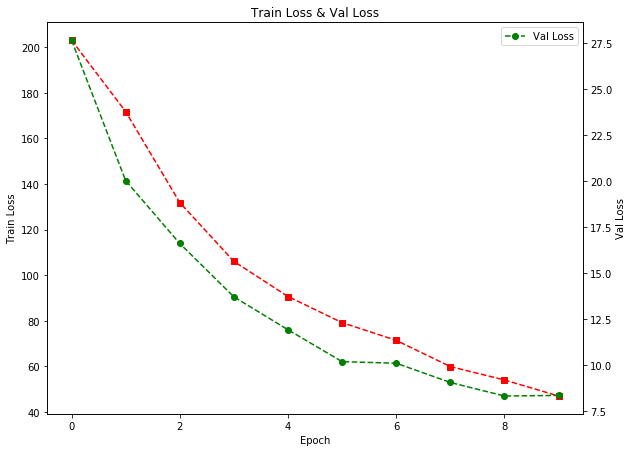

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax0 = plt.subplots(figsize=(9.6,7.2))
ax1 = ax0.twinx()
ax0.set_title("Train Loss & Val Loss")
ax0.plot(all_train_loss, 'rs--', label="Train Loss")
ax0.set_ylabel("Train Loss")
ax0.grid(False)
ax1.plot(all_val_loss, 'go--', label="Val Loss")
ax1.set_ylabel("Val Loss")
ax1.grid(False)
ax0.set_xlabel("Epoch")
plt.legend(loc=1)
plt.show()

## 6. Test the network on the test data

In [9]:
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = net(images).reshape(batch_size, num_classes)
        
        _, predicted = torch.max(outputs, dim=1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' %(100 * correct / total)) # more than 10 percent

Accuracy of the network on the 10000 test images: 77 %
